Introduction:


This notebook is for the algorithm that use trees(after tokenized from time series data) to convert as function.

This converted function only shows the general trend but not the specific data. We have two choice to visualized the converted function, one without smoothness and the other one with smoothness, what's more, we can customize the smoothness threshold to change the shape of the function. 

In [118]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline
from datetime import datetime

load data

data comes from https://www.marketwatch.com/investing/stock/aapl/download-data

using six monthes data of Apple stock: Apple_stock_data_6M.csv

In [86]:
data = pd.read_csv('/Users/eeevashen/Desktop/Apple_stock_data_6M.csv',low_memory=False)
# take out the Date column and Close/Last column
data = data[['Date','Close/Last']]
# make the whole dataframe upside down
data = data[::-1]
# seperate the Date column by month
data['Date'] = pd.to_datetime(data['Date'])
data['Month'] = data['Date'].dt.month
data['Date'] = data['Date'].dt.strftime('%Y-%m-%d')
# make the Close/Last column as float
data['Close/Last'] = data['Close/Last'].str.replace('$','').astype(float)
# make the Date column and Close/Last column as a tuple
tuple_data = list(zip(data['Date'],data['Close/Last']))

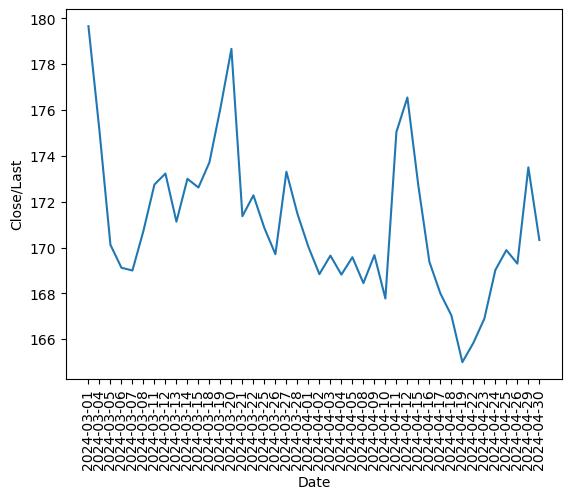

In [87]:
# pick month=4 5 6 data to plot
data = data[data['Month'].isin([3,4])]
# data = data[data['Month']==4]
# plot the data
plt.plot(data['Date'],data['Close/Last'])
plt.xlabel('Date')
plt.ylabel('Close/Last')
# make the x-axis label lilted
plt.xticks(rotation=90)
plt.show()

In [88]:
time_series = (data['Close/Last'].tolist(), data['Date'].tolist())

Function define:

In [89]:
def modify(original_time_series, bar_lists, difference=0):
  indices_to_be_updated_list = []
  values_to_be_updated_list = []
  for bar_list in bar_lists:
    start_idx = bar_list[0][0]
    start_val = bar_list[0][1]
    end_idx = bar_list[1][0]
    end_val = bar_list[1][1]
    if start_val - end_val > difference: # check bar display(right)
      continue
    # ---
    #  |
    #  |
    if start_idx < end_idx:
      indices_to_be_updated = []
      for i in range(start_idx+1, len(original_time_series)):
        if original_time_series[i] <= start_val:
          indices_to_be_updated.append(i)
        else:
          break
      values_to_be_updated = start_val
    # ---
    # |
    # |
    else:                                # check bar display(left)
      indices_to_be_updated = []
      for i in reversed(range(0, start_idx)):
        if original_time_series[i] <= start_val:
          indices_to_be_updated.append(i)
        else:
          break
      values_to_be_updated = start_val
    indices_to_be_updated_list.append(indices_to_be_updated)
    values_to_be_updated_list.append(values_to_be_updated)
  print(indices_to_be_updated_list)
  print(values_to_be_updated_list)
  return indices_to_be_updated_list, values_to_be_updated_list


def get_result(time_series, indices_to_be_updated_list, values_to_be_updated_list):
  result = time_series.copy()
  for indices_to_be_updated, values_to_be_updated in zip(indices_to_be_updated_list, values_to_be_updated_list):
    for idx in indices_to_be_updated:
      result[idx] = max(result[idx], values_to_be_updated)
  return result

def get_result_remove(time_series, date_series, indices_to_be_updated_list, values_to_be_updated_list):
  for indices_to_be_updated, values_to_be_updated in zip(indices_to_be_updated_list, values_to_be_updated_list):
    for idx in indices_to_be_updated:
      time_series = time_series.pop(idx)
      date_series = date_series.pop(idx)
  return time_series, date_series

In [90]:
def one_pass_bar_algorithm(time_series, date_list=None, print_bars=True):
    bar_list = []
    maxima, minima = [], []
    direction = 1

    # add a very small point at the front of the time_series
    time_series = [time_series[0] - 1e-6] + time_series
    # add a very big point at the end of the time_series
    time_series = time_series + [time_series[-1] + 1e-6]

    for t in range(0, len(time_series)-1):
        if (time_series[t+1] - time_series[t]) * direction < 0:
            if direction == 1:
                if len(maxima) != 0 and time_series[t] > maxima[-1][1]:
                    output_bar(maxima.pop(), minima.pop(),date_list, bar_list, print_bars)
                maxima.append((t, time_series[t])) 
            else:
                if len(minima) != 0 and time_series[t] < minima[-1][1]:
                    output_bar(maxima.pop(), minima.pop(),date_list, bar_list, print_bars)
                minima.append((t, time_series[t]))
            direction = -direction
        else:
          if direction == 1 and len(maxima) != 0 and time_series[t] > maxima[-1][1]:
              output_bar(maxima.pop(), minima.pop(),date_list, bar_list, print_bars)
          elif direction == -1 and len(minima) != 0 and time_series[t] < minima[-1][1]:
              output_bar(maxima.pop(), minima.pop(),date_list, bar_list, print_bars)
    output_remaining_bars(maxima, minima, date_list, bar_list, print_bars)
    return bar_list

def output_bar(max_value, min_value, date_list, bar_list, print_bars):
    if date_list is None:
        length = max_value[1] - min_value[1]
        if print_bars == True:
            print(f"(normal)Bar: ({max_value[0]}, {max_value[1]}) to ({min_value[0]}, {min_value[1]}), length: {length}")
        bar_list.append(((max_value[0], max_value[1]), (min_value[0], min_value[1]), length))

    else:
        length = max_value[1] - min_value[1]
        if print_bars == True:
            print(f"(normal)Bar: ({date_list[max_value[0]-1]}, {max_value[1]}) to ({date_list[min_value[0]-1]}, {min_value[1]}), length: {length}")
        bar_list.append(((date_list[max_value[0]-1], max_value[1]), (date_list[min_value[0]-1], min_value[1]), length))

def output_remaining_bars(maxima, minima, date_list, bar_list, print_bars):
    if date_list is None:
        for i in range(min(len(maxima), len(minima))):
            length = maxima[i][1] - minima[i][1]
            if print_bars == True:
                print(f"(remaining)Bar: ({maxima[i][0]}, {maxima[i][1]}) to ({minima[i][0]}, {minima[i][1]}), length: {length}")
            bar_list.append(((maxima[i][0], maxima[i][1]),  (minima[i][0], minima[i][1]), length))

    else:
        for i in range(min(len(maxima), len(minima))):
            length = maxima[i][1] - minima[i][1]
            if print_bars == True:
                print(f"(remaining)Bar: ({date_list[maxima[i][0]-1]}, {maxima[i][1]}) to ({date_list[minima[i][0]-1]}, {minima[i][1]}), length: {length}")
            bar_list.append(((date_list[maxima[i][0]-1], maxima[i][1]), (date_list[minima[i][0]-1], minima[i][1]), length))


In [91]:
def separate_series_by_length(time_series, length = 10):
    length_tmp = 0
    tree_set = []
    value_tmp = []
    date_tmp = []
    bar_set = []
    for value, date in zip(*time_series):
        value_tmp.append(value)
        date_tmp.append(date)
        # print(value, date)
        # print(type(value), type(date))
        bar_list = one_pass_bar_algorithm(value_tmp, date_tmp, False)
        length_tmp = 0
        for bar in bar_list:
            # print(bar)
            length_tmp += bar[2]
            bar_set.append(bar)
            if length_tmp > length:
                tree_set.append(((value_tmp, date_tmp), length_tmp))
                value_tmp = []
                date_tmp = []
                length_tmp = 0
                break
            # else:
            #     length_tmp += bar[2]
    return tree_set # return a list of tuple, each tuple contains a tuple of time_series and a length, which is the tree structure here


# use the tree_set to find the bar set for each tree's date period
def find_valid_bar(tree_set):
    bar_set = []
    for tree in tree_set:
        time_series = tree[0]
        length = tree[1]
        bar_list = one_pass_bar_algorithm(time_series[0], time_series[1], False)
        bar_set.append(bar_list)
    return bar_set
        

In [92]:
(value, date) = time_series
one_pass_bar_algorithm(value, date)

(normal)Bar: (2024-03-14, 173.0) to (2024-03-15, 172.62), length: 0.37999999999999545
(normal)Bar: (2024-03-12, 173.23) to (2024-03-13, 171.13), length: 2.0999999999999943
(normal)Bar: (2024-03-22, 172.28) to (2024-03-21, 171.37), length: 0.9099999999999966
(normal)Bar: (2024-03-27, 173.31) to (2024-03-26, 169.71), length: 3.5999999999999943
(normal)Bar: (2024-04-03, 169.65) to (2024-04-02, 168.84), length: 0.8100000000000023
(normal)Bar: (2024-04-05, 169.58) to (2024-04-04, 168.82), length: 0.7600000000000193
(normal)Bar: (2024-04-09, 169.67) to (2024-04-08, 168.45), length: 1.2199999999999989
(normal)Bar: (2024-04-12, 176.55) to (2024-04-10, 167.78), length: 8.77000000000001
(normal)Bar: (2024-03-20, 178.67) to (2024-03-07, 169.0), length: 9.669999999999987
(normal)Bar: (2024-04-25, 169.89) to (2024-04-26, 169.3), length: 0.589999999999975
(remaining)Bar: (2024-03-01, 179.66) to (2024-04-19, 165.0), length: 14.659999999999997
(remaining)Bar: (2024-04-29, 173.5) to (2024-04-30, 170.33

[(('2024-03-14', 173.0), ('2024-03-15', 172.62), 0.37999999999999545),
 (('2024-03-12', 173.23), ('2024-03-13', 171.13), 2.0999999999999943),
 (('2024-03-22', 172.28), ('2024-03-21', 171.37), 0.9099999999999966),
 (('2024-03-27', 173.31), ('2024-03-26', 169.71), 3.5999999999999943),
 (('2024-04-03', 169.65), ('2024-04-02', 168.84), 0.8100000000000023),
 (('2024-04-05', 169.58), ('2024-04-04', 168.82), 0.7600000000000193),
 (('2024-04-09', 169.67), ('2024-04-08', 168.45), 1.2199999999999989),
 (('2024-04-12', 176.55), ('2024-04-10', 167.78), 8.77000000000001),
 (('2024-03-20', 178.67), ('2024-03-07', 169.0), 9.669999999999987),
 (('2024-04-25', 169.89), ('2024-04-26', 169.3), 0.589999999999975),
 (('2024-03-01', 179.66), ('2024-04-19', 165.0), 14.659999999999997),
 (('2024-04-29', 173.5), ('2024-04-30', 170.33), 3.1699999999999875)]

(normal)Bar: (10, 173.0) to (11, 172.62), length: 0.37999999999999545
(normal)Bar: (8, 173.23) to (9, 171.13), length: 2.0999999999999943
(normal)Bar: (16, 172.28) to (15, 171.37), length: 0.9099999999999966
(normal)Bar: (19, 173.31) to (18, 169.71), length: 3.5999999999999943
(normal)Bar: (23, 169.65) to (22, 168.84), length: 0.8100000000000023
(normal)Bar: (25, 169.58) to (24, 168.82), length: 0.7600000000000193
(normal)Bar: (27, 169.67) to (26, 168.45), length: 1.2199999999999989
(normal)Bar: (30, 176.55) to (28, 167.78), length: 8.77000000000001
(normal)Bar: (14, 178.67) to (5, 169.0), length: 9.669999999999987
(normal)Bar: (39, 169.89) to (40, 169.3), length: 0.589999999999975
(remaining)Bar: (1, 179.66) to (35, 165.0), length: 14.659999999999997
(remaining)Bar: (41, 173.5) to (42, 170.33), length: 3.1699999999999875
[[], [9, 10], [15, 14], [22, 21], [24, 23], [26, 25, 24, 23, 22, 21], []]
[173.0, 173.23, 172.28, 169.65, 169.58, 169.67, 169.89]


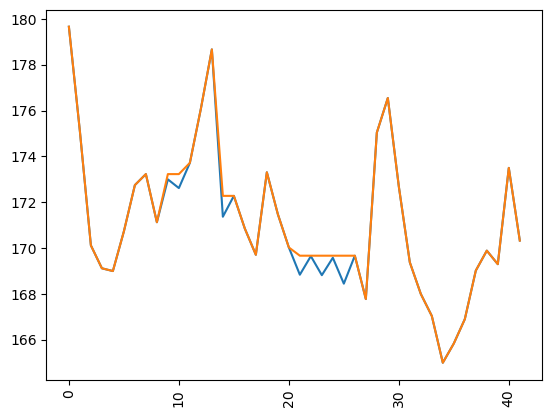

In [93]:
time_series_removeing = data['Close/Last'].tolist()
bar_list_removing = one_pass_bar_algorithm(time_series_removeing)
indices_to_be_updated_list, values_to_be_updated_list = modify(time_series_removeing, bar_list_removing, difference = 3)
updated_time_series = get_result(time_series_removeing, indices_to_be_updated_list, values_to_be_updated_list)
plt.figure()
plt.plot(time_series_removeing)
plt.plot(updated_time_series)
plt.xticks(rotation=90)
plt.show()

In [94]:
time_series_cleaned = (updated_time_series, date)

In [95]:
print(time_series_cleaned)

([179.66, 175.1, 170.12, 169.12, 169.0, 170.73, 172.75, 173.23, 171.13, 173.23, 173.23, 173.72, 176.08, 178.67, 172.28, 172.28, 170.85, 169.71, 173.31, 171.48, 170.03, 169.67, 169.67, 169.67, 169.67, 169.67, 169.67, 167.78, 175.04, 176.55, 172.69, 169.38, 168.0, 167.04, 165.0, 165.84, 166.9, 169.02, 169.89, 169.3, 173.5, 170.33], ['2024-03-01', '2024-03-04', '2024-03-05', '2024-03-06', '2024-03-07', '2024-03-08', '2024-03-11', '2024-03-12', '2024-03-13', '2024-03-14', '2024-03-15', '2024-03-18', '2024-03-19', '2024-03-20', '2024-03-21', '2024-03-22', '2024-03-25', '2024-03-26', '2024-03-27', '2024-03-28', '2024-04-01', '2024-04-02', '2024-04-03', '2024-04-04', '2024-04-05', '2024-04-08', '2024-04-09', '2024-04-10', '2024-04-11', '2024-04-12', '2024-04-15', '2024-04-16', '2024-04-17', '2024-04-18', '2024-04-19', '2024-04-22', '2024-04-23', '2024-04-24', '2024-04-25', '2024-04-26', '2024-04-29', '2024-04-30'])


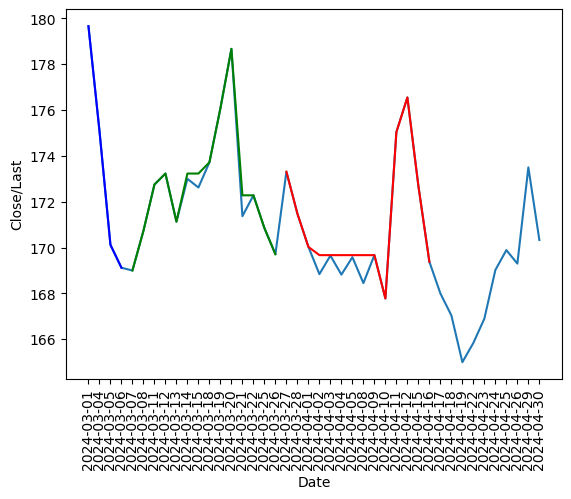

In [96]:
tree_set = separate_series_by_length(time_series_cleaned)
#plot the bar_set on the graph using different colors for different bars
data = data[data['Month'].isin([3,4])]
# data = data[data['Month']==4]
# plot the data
plt.plot(data['Date'],data['Close/Last'])
plt.xlabel('Date')
plt.ylabel('Close/Last')
# make the x-axis label lilted
plt.xticks(rotation=90)

color = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
for i, bar in enumerate(tree_set):
    value, date = bar[0]
    plt.plot(date, value, color=color[i%8])
plt.show()

In [97]:
bar_set_for_tree = find_valid_bar(tree_set)
print(bar_set_for_tree)

[[(('2024-03-01', 179.66), ('2024-03-06', 169.12), 10.539999999999992)], [(('2024-03-12', 173.23), ('2024-03-13', 171.13), 2.0999999999999943), (('2024-03-20', 178.67), ('2024-03-26', 169.71), 8.95999999999998)], [(('2024-03-27', 173.31), ('2024-04-10', 167.78), 5.530000000000001), (('2024-04-12', 176.55), ('2024-04-16', 169.38), 7.170000000000016)]]


convert tree to fucntion

After this block is the meaningful part of this notebook

this tree_convert_to_function takes bar_set_for_tree which is the output from the find_valid_bar means a bar information of tokenized tree.

And the output will be a converted function plot

In [125]:
def tree_convert_to_function(bar_set_for_tree,smooth=True, smoothness=300):
    # Flatten the list to extract all date-value pairs
    flattened_data = []
    for sublist in bar_set_for_tree:
        for entry in sublist:
            flattened_data.append(entry[0])
            flattened_data.append(entry[1])

    # Separate dates and values
    dates = [item[0] for item in flattened_data]
    values = [item[1] for item in flattened_data]

    # Find the minimum and maximum values
    min_value = min(values)
    max_value = max(values)
    min_index = values.index(min_value)
    max_index = values.index(max_value)

    x_dates_dt = [datetime.strptime(date, "%Y-%m-%d") for date in dates]
    x_numeric = np.arange(len(x_dates_dt))
    x_new_numeric = np.linspace(x_numeric.min(), x_numeric.max(), smoothness)  # 300 points for smoothness
    spl = make_interp_spline(x_numeric, values, k=3)  # k=3 is for cubic spline
    y_smooth = spl(x_new_numeric)

    plt.figure(figsize=(10, 5))
    # Customize the plot
    if smooth == False:
        # Plot the data
        plt.plot(dates, values, marker='o')
        plt.xlabel('Date')
        plt.ylabel('Value')
        plt.title('Convert back to function(without smoothing)')
        plt.grid(True)
        plt.xticks(rotation=45)
        plt.tight_layout()
    else:
        plt.plot(x_new_numeric, y_smooth, label='Smooth Curve')
        x_new_dates = np.interp(x_new_numeric, x_numeric, np.arange(len(x_dates_dt)))
        plt.xticks(x_numeric, dates, rotation=45)
        plt.xlabel('Date')
        plt.ylabel('Value')
        plt.title('Convert back to function(with smoothing)')
        plt.grid(True)
        plt.tight_layout()
    
    # Show the plot
    plt.show()


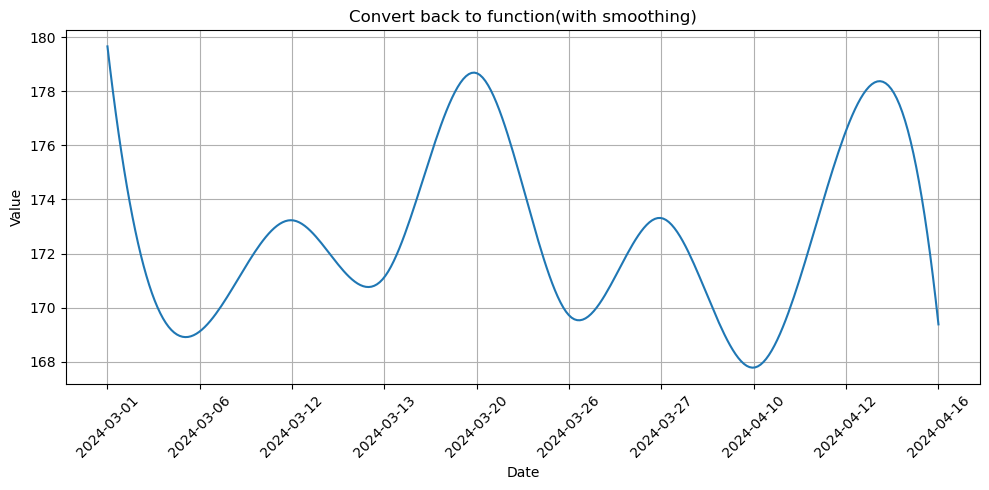

In [126]:
tree_convert_to_function(bar_set_for_tree)